In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib notebook

from fastbook import *
from fastai import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import ImagesCleaner
from fastai.metrics import error_rate

import matplotlib.pyplot as plt
import signal
import os, sys, cv2, shutil, tarfile
import numpy as np

In [11]:
tf = tarfile.open("kaggle dataset/input/fer2013.tar.gz")
tf.extractall()

In [4]:
output_path = "images"

if os.path.exists(output_path):
    os.system('rm -rf {}'.format(output_path))

os.system('mkdir {}'.format(output_path))

label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

data = np.genfromtxt('fer2013/fer2013.csv',delimiter=',',dtype=None, encoding=None)
labels = data[1:,0].astype(np.int32)
image_buffer = data[1:,1]
images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in image_buffer])
usage = data[1:,2]
dataset = zip(labels, images, usage)
usage_path = ""
for i, d in enumerate(dataset):
    if(d[-1] == "Training" or d[-1] == "PrivateTest"):
        usage_path = os.path.join(output_path, "Training")
    else:
        usage_path = os.path.join(output_path, d[-1])

    label_path = os.path.join(usage_path, label_names[d[0]])
    img = d[1].reshape((48,48))
    img_name = '%08d.jpg' % i
    img_path = os.path.join(label_path, img_name)
    if not os.path.exists(usage_path):
        os.system('mkdir {}'.format(usage_path))
    if not os.path.exists(label_path):
        os.system('mkdir {}'.format(label_path))
    cv2.imwrite(img_path, img)

In [2]:
np.random.seed(42)
data = ImageDataLoaders.from_folder(path = 'images', train = "Training", 
                                    valid_pct=0.2,item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats), bs = 32)

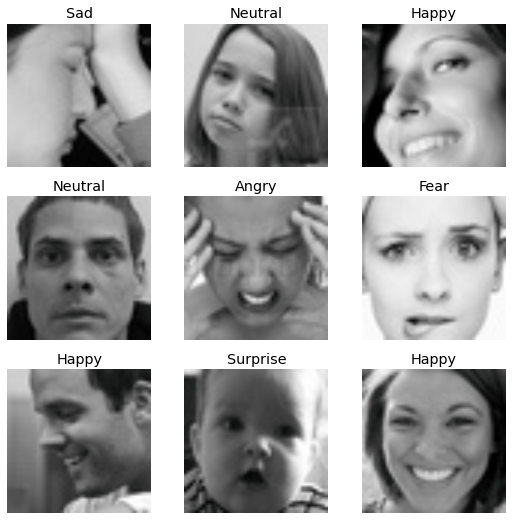

In [4]:
data.show_batch()

In [3]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate)

In [6]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.421865,1.174220,0.451024,24:08
1,1.085003,0.974801,0.363383,24:07
2,0.945798,0.873876,0.323534,24:07
3,0.760110,0.859080,0.313501,26:13


In [7]:
learn.save('stage-1')

Path('images/models/stage-1.pth')

In [8]:
learn.load('stage-1')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

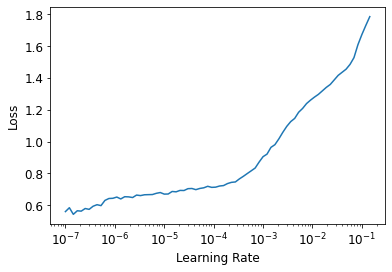

In [9]:
learn.unfreeze()
learn.lr_find()

In [11]:
learn.fit_one_cycle(4, lr_max=slice(3e-6,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.139443,1.076289,0.400725,31:41
1,0.973295,0.895836,0.331058,31:40
2,0.646638,0.839408,0.297478,31:39
3,0.295409,0.957857,0.293716,31:47


In [12]:
learn.save('stage-2')

Path('images/models/stage-2.pth')

In [5]:
learn.load('stage-2')

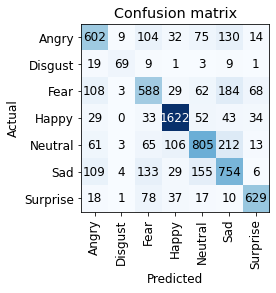

In [17]:
learn.unfreeze()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=2.75422871709452e-06)

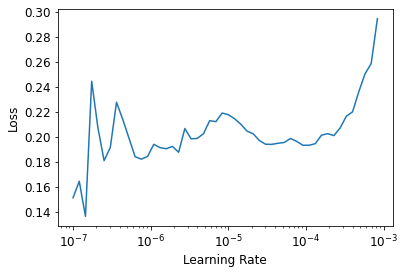

In [6]:
learn.unfreeze()
learn.lr_find()

In [7]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(3e-7,3e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.193835,0.958197,0.291347,31:32
1,0.185104,0.963801,0.294691,31:32
2,0.177179,0.978506,0.295249,31:33
3,0.165099,0.974462,0.294552,31:34


In [8]:
learn.save('stage-3')

Path('images/models/stage-3.pth')

In [5]:
learn.load('stage-3')
learn.unfreeze()

In [9]:
btn_upload = widgets.FileUpload()

In [27]:
btn_upload

FileUpload(value={'Smilingman.jpg': {'metadata': {'name': 'Smilingman.jpg', 'type': 'image/jpeg', 'size': 2058…

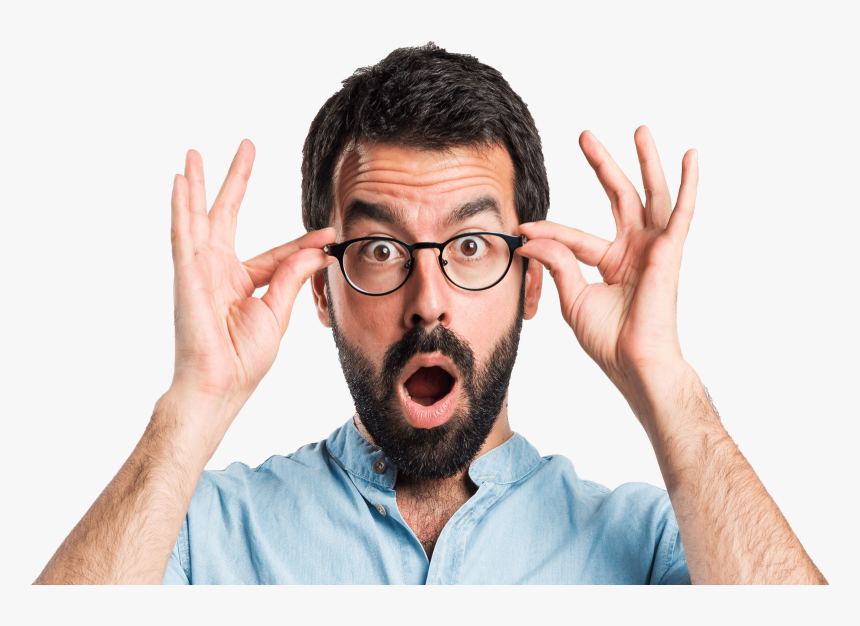

In [30]:
img = PILImage.create(btn_upload.data[-1])
img

In [36]:
learn.predict(img)

('Surprise',
 tensor(6),
 tensor([3.2133e-23, 1.4398e-32, 7.4635e-14, 4.0012e-40, 1.8259e-38, 2.6835e-40, 1.0000e+00]))